In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import requests
import seaborn as sns
from IPython.display import display, Markdown
from matplotlib.lines import Line2D
%matplotlib inline

# Get article and population data

In [390]:
# Read the page data

page_data_df = pd.read_csv('country/data/page_data.csv')
page_data_df.head()

,page,country,rev_id
0,Template:ZambiaProvincialMinisters,Zambia,235107991
1,Bir I of Kanem,Chad,355319463
2,Template:Zimbabwe-politician-stub,Zimbabwe,391862046
3,Template:Uganda-politician-stub,Uganda,391862070
4,Template:Namibia-politician-stub,Namibia,391862409


In [391]:
# Read the population data

pop_df = pd.read_csv('WPDS_2018_data.csv')
pop_df.head()

,Geography,Population mid-2018 (millions)
0,AFRICA,"1,284"
1,Algeria,42.7
2,Egypt,97
3,Libya,6.5
4,Morocco,35.2


# Combine the datasets

In [392]:
# Convert countries to lower case to merge the datasets using it

page_data_df['country'] = page_data_df['country'].apply(lambda x: x.lower())
pop_df['Geography'] = pop_df['Geography'].apply(lambda x: x.lower())

In [393]:
# Merge the datasets

final_df = pd.merge(page_data_df, pop_df, how='inner', left_on='country', right_on='Geography')

In [394]:
# Drop duplication column for country
final_df.drop(['Geography'], axis=1, inplace=True)

# Rename the column names as per requirement
final_df.columns = ['article_name', 'country', 'revision_id', 'population (millions)']

# Add new column for article quality
final_df['article_quality'] = np.NaN

# Re-order all columns as per requirment
final_df = final_df[['country', 'article_name', 'revision_id', 'article_quality', 'population (millions)']]

# Review the final dataset
final_df.head()

,country,article_name,revision_id,article_quality,population (millions)
0,zambia,Template:ZambiaProvincialMinisters,235107991,NaN,17.7
1,zambia,Gladys Lundwe,757566606,NaN,17.7
2,zambia,Mwamba Luchembe,764848643,NaN,17.7
3,zambia,Thandiwe Banda,768166426,NaN,17.7
4,zambia,Sylvester Chisembele,776082926,NaN,17.7


In [395]:
# Print no. of documents that couldn't be matched

len(page_data_df) - len(final_df)

2120

# Fetch article quality predictions

In [397]:
# Setup values

url = "https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revid}"
params = {'project':'enwiki', 'model':'wp10'}

In [398]:
# Function to take ORES API response as input and update final dataset with article quality score

def update_scores(resp):
    global final_df
    
    # Function to extract score for a single revision id from the json response of API
    def extract_score(rev_id):
        try:
            score = resp[params['project']]['scores'][rev_id][params['model']]['score']['prediction']
        except:
            score = np.NaN
        return score
    
    rev_ids = list(resp[params['project']]['scores'].keys())
    scores = list(map(extract_score, rev_ids))
    for rev_id, score in zip(rev_ids, scores):
        final_df.loc[final_df['revision_id'] == int(rev_id), 'article_quality'] = score

In [399]:
# Fetch the article quality score using ORES API for each page in the final dataset

chunk_size = 100
ptr = 0
done = False
while not done:
    chunk = final_df.loc[ptr:ptr+chunk_size, ['revision_id']].values.ravel().astype(str)
    if chunk.size == 0:
        done = True
        print("All Done!")
        break
    else:
        params['revid'] = "|".join(chunk)
        response = requests.get(url.format(**params)).json()
        update_scores(response)
        ptr += chunk_size
    if ptr % 10000 == 0:
        print(ptr, ' revision ids processed')

10000  revision ids processed
20000  revision ids processed
30000  revision ids processed
40000  revision ids processed
All Done!


In [400]:
# Drop the rows for which the quality score could not be found
final_df.dropna(subset=['article_quality'], inplace=True)

# Review the final dataset
final_df.head()

,country,article_name,revision_id,article_quality,population (millions)
1,zambia,Gladys Lundwe,757566606,Stub,17.7
2,zambia,Mwamba Luchembe,764848643,Stub,17.7
3,zambia,Thandiwe Banda,768166426,Start,17.7
4,zambia,Sylvester Chisembele,776082926,C,17.7
5,zambia,Victoria Kalima,776530837,Start,17.7


# Save the combined dataset with article quality scores

In [401]:
# Save the final dataset in csv format
final_df.to_csv('combined_data.csv', index=False)
print('File "/combined_data.csv" saved!')

File "/combined_data.csv" saved!


# Analysis

## Table 1

In [402]:
# Get count of articles and population values for each country in alphabetical order of countries

countries_sorted = final_df['country'].sort_values().unique()
article_counts = final_df['country'].value_counts().sort_index().values
populations = final_df[['country', \
                        'population (millions)']].sort_values(by='country').drop_duplicates()['population (millions)'].values
populations = list(map(lambda x: float(x.replace(",", "")), populations))

# Create a dataframe with countries, article counts and proportions per population
columns = ['country', 'article_counts', 'population (millions)']
total_proportion_df = pd.DataFrame(np.column_stack((countries_sorted, article_counts, populations)), columns=columns)
total_proportion_df['proportion %'] = total_proportion_df['article_counts'] * 100 \
/ (total_proportion_df['population (millions)'] * 1000000)
# Create Table 1
table1 = total_proportion_df.sort_values(by='proportion %', ascending=False).iloc[:10]
table1.reset_index(drop=True, inplace=True)
display(Markdown('# 10 highest-ranked countries in terms of no. of politician articles as a proportion of country population'))
table1.index += 1
table1

# 10 highest-ranked countries in terms of no. of politician articles as a proportion of country population

,country,article_counts,population (millions),proportion %
1,tuvalu,55,0.01,0.55
2,nauru,53,0.01,0.53
3,san marino,82,0.03,0.273333
4,monaco,40,0.04,0.1
5,liechtenstein,29,0.04,0.0725
6,tonga,63,0.1,0.063
7,marshall islands,37,0.06,0.0616667
8,iceland,206,0.4,0.0515
9,andorra,34,0.08,0.0425
10,federated states of micronesia,38,0.1,0.038


## Observation:
- As expected, the countries with lower populations were going to be on top as having just a few articles would significantly boost the proportion which is computed as a percentage. Though I didn't expect to see countries like Tuvalu and Nauru which I had not heard of until now. Proportion based on overall population is probabaly not the best way to analyze this data.
- Iceland appears to pop out of this list above with highest no. of articles.

## Table 2

In [403]:
# Create Table 2
table2 = total_proportion_df.sort_values(by='proportion %', ascending=True).iloc[:10]
table2.reset_index(drop=True, inplace=True)
display(Markdown('# 10 lowest-ranked countries in terms of no. of politician articles as a proportion of country population'))
table2.index += 1
table2

# 10 lowest-ranked countries in terms of no. of politician articles as a proportion of country population

,country,article_counts,population (millions),proportion %
1,india,986,1371.3,7.19026e-05
2,indonesia,214,265.2,8.06938e-05
3,china,1135,1393.8,8.14321e-05
4,uzbekistan,29,32.9,8.81459e-05
5,ethiopia,105,107.5,9.76744e-05
6,zambia,25,17.7,0.000141243
7,"korea, north",39,25.6,0.000152344
8,thailand,112,66.2,0.000169184
9,bangladesh,323,166.4,0.000194111
10,mozambique,60,30.5,0.000196721


## Observation:
- Once again, since we are ranking based on proportion computed on overall population, the countries with highest populations with English not as their primary language are expected to feature here. 
- Another expectation is also to see some under-developed countries with relativley limited access to internet. For example the African countries in the list above.

# Table 3

In [404]:
final_high_qual_df = final_df[(final_df['article_quality'] == 'FA') | (final_df['article_quality'] == 'GA')]

high_quality_article_counts = final_high_qual_df['country'].value_counts().sort_index().values
high_quality_countries_sorted = final_high_qual_df['country'].sort_values().unique()
columns2 = ['country', 'high_quality_article_counts']
high_quality_proportion_df = pd.DataFrame(np.column_stack((high_quality_countries_sorted, high_quality_article_counts)), \
                                          columns=columns2)

high_quality_proportion_df = pd.merge(total_proportion_df, \
                                      high_quality_proportion_df[['country', 'high_quality_article_counts']], \
                                      how='left', on='country')
high_quality_proportion_df.fillna(0, inplace=True)
high_quality_proportion_df['proportion %'] = high_quality_proportion_df['high_quality_article_counts'] * 100 \
/ (high_quality_proportion_df['article_counts'])

# Create Table 3
table3 = high_quality_proportion_df.sort_values(by='proportion %', \
                                                ascending=False)[['country', \
                                                                  'article_counts', \
                                                                  'high_quality_article_counts', \
                                                                  'proportion %']].iloc[:10]
table3.reset_index(drop=True, inplace=True)
display(Markdown('# 10 highest-ranked countries in terms of no. of GA and FA-quality articles' + \
                 ' as a proportion of all articles about politicians from that country'))
table3.index += 1
table3

# 10 highest-ranked countries in terms of no. of GA and FA-quality articles as a proportion of all articles about politicians from that country

,country,article_counts,high_quality_article_counts,proportion %
1,"korea, north",39,7,17.948718
2,saudi arabia,119,16,13.445378
3,central african republic,68,8,11.764706
4,romania,348,40,11.494253
5,mauritania,52,5,9.615385
6,bhutan,33,3,9.090909
7,tuvalu,55,5,9.090909
8,dominica,12,1,8.333333
9,united states,1092,82,7.509158
10,benin,94,7,7.446809


## Observation:
- It is very interesting to find North Korea and Saudi Arabia on top of this list considering the tight control on freedom of overall speech in both countries.
- It is also interesting to see that USA has only 82 high quality articles out of a total of 1092. Though 82 is highest in the list, it is ranked 9 due to the ranking based on proportion.
- To dig deeper, we'll need to understand the ORES API Scoring algorithm and find out what attributes contribute towards a higher score.

# Table 4

In [405]:
# Create Table 4
table4 = high_quality_proportion_df[high_quality_proportion_df['high_quality_article_counts'] == 0]
table4 = table4.sort_values(by='article_counts', ascending=False)[['country', \
                                                          'article_counts', \
                                                          'high_quality_article_counts', \
                                                          'proportion %']]
table4.reset_index(drop=True, inplace=True)
display(Markdown('# All lowest-ranked countries in terms of no. of GA and FA-quality articles' + \
                 ' as a proportion of all articles about politicians from that country'))
table4.index += 1
table4

# All lowest-ranked countries in terms of no. of GA and FA-quality articles as a proportion of all articles about politicians from that country

,country,article_counts,high_quality_article_counts,proportion %
1,finland,572,0,0.0
2,belgium,523,0,0.0
3,moldova,426,0,0.0
4,switzerland,407,0,0.0
5,nepal,361,0,0.0
6,uganda,188,0,0.0
7,costa rica,150,0,0.0
8,tunisia,140,0,0.0
9,slovakia,119,0,0.0
10,angola,110,0,0.0


## Observation:
- All the above countries have the zero high quality articles.
- The countries have been ranked based on the total no. of articles published. Country with highest no. of articles with not a single high quality article is ranked as 1.
- It is interesting to see developed countries like Finland, Belgium and Switzerland have a good count of articles, but zero high quality ones. It is hard to speculate without understanding the scoring mechanism. If I had to hazard a guess, I would attribute the lack of high quality to the fact that English is not the primary language of these countries.

# Analysis of Countries with most articles

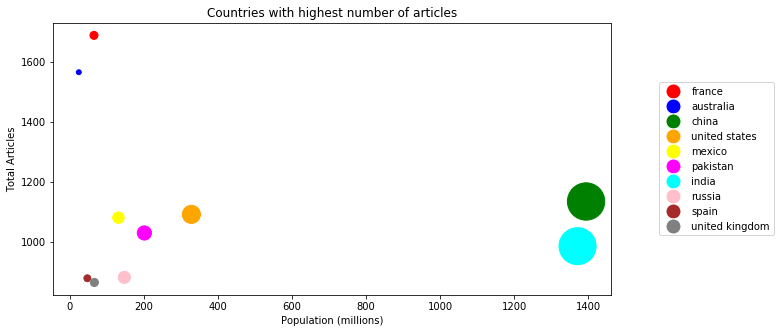

In [407]:
most_articles_df = total_proportion_df.sort_values(by='article_counts', ascending=False).head(10)
most_articles_df['population'] = most_articles_df['population (millions)'].apply(round)
plt.figure(figsize=(10,5))
colors=['red', 'blue', 'green', 'orange', 'yellow', 'magenta', 'cyan', 'pink', 'brown', 'gray']
cols = dict(zip(most_articles_df['country'].values,colors))
plt.scatter(x='population', y='article_counts', data=most_articles_df, s='population', c=colors)
legend_items = [Line2D([0], [0], marker='o', color='w', label=key,
                          markerfacecolor=value, markersize=15) for key, value in cols.items()]
plt.legend(handles=legend_items, loc='right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Population (millions)')
plt.ylabel('Total Articles')
plt.title('Countries with highest number of articles')

## Data Representation:
- X-axis encodes the population (millions).
- Y-axis encodes the total no. of English articles related to politicians. 
- Hue encodes countries.
- Size of the markers also encode population (millions) for better visual comparison

## Observations:
- Though China and India have highest population, they don't have the highest no. of articles. The reason could be attributed to the fact that English is not the native language of these countries and they may have far more articles published about politicians in other medium for wider reach.
- What stands out is the fact the China has more English articles related to politics as compared to USA especially considering how tightly controlled political speech in China is. Though articles per person would tip the scale in favor of USA, I was still expecting USA to be on top in total count as well.
- Considering the fact that English is most widely spoken in the countries USA and UK and both have vibrant political systems, I was expecting most articles to be from one of them. To my surprise, France has the highest number even though English is not its native language.
- Even though Australia is primarily English speaking country, I didn't expect it to stand way above USA in total count of articles, considering the fact the USA has a population more than 10 times that of population of Australia.
- We don't see any country in the top 10 from the continents of Africa and South America. Brazil with a population of around 200 million is noticeable miss.

# Conclusion:
In each segment of anlaysis above the expected biases have been mentioned. Contrary findings and results have also been mentioned. One theory I have about some of the unexpected findings is that, while considering population in computation of proportion, we are using overall population. Instead we should fine tune it to include only the English speaking educated class with access to internet to level the playing field.